# Comparison of GLIF models for my implementation and that in Teeter et al. (2018)


## Run Allen simulation

In [1]:
### Adapted from https://github.com/AllenInstitute/GLIF_Teeter_et_al_2018 ###
from pathlib import Path
import numpy as np
import pickle
import os
import allensdk.core.json_utilities as ju
from allensdk.model.glif.glif_neuron import GlifNeuron
from allensdk.core.cell_types_cache import CellTypesCache
import sys
sys.path.append(str(Path('./GLIF_Teeter_et_al_2018/libraries').resolve()))
import time
from GLIF_Teeter_et_al_2018.libraries.data_library import get_file_path_endswith, get_sweep_num_by_name
import json
import matplotlib.pyplot as plt 

relative_path=os.path.dirname(os.getcwd())
ctc = CellTypesCache(manifest_file=os.path.join(relative_path,'cell_types_manifest.json'))
GLIF_dict = {
    "LIF_model":"GLIF1",
    "LIFR_model":"GLIF2",
    "LIFASC_model":"GLIF3",
    "LIFRASC_model":"GLIF4",
    "LIFRASCAT_model":"GLIF5"}

def get_model(path, EW):
    '''Runs the model for a specified neuron and model
    inputs:
        path: string
            folder path with files for the neuron
        EW: string
            end of file searching for:  options '_GLIF1_neuron_config.json',_GLIF2_neuron_config.json' etc.
    returns:
        run_data: dictionary
            contains data from the model run
            
   '''

    specimen_id=int(os.path.basename(path)[:9])
    file=get_file_path_endswith(path, EW)

    # load data
    dir_name=os.path.join(relative_path, 'mouse_nwb/specimen_'+ str(specimen_id))
    all_sweeps=ctc.get_ephys_sweeps(specimen_id,  os.path.join(dir_name, 'ephys_sweeps.json'))
    sweeps=get_sweep_num_by_name(all_sweeps, 'Noise 2')
    
    noise2_sweeps = get_sweep_num_by_name(all_sweeps, 'Noise 2')
    noise2_data=ctc.get_ephys_data(specimen_id, os.path.join(dir_name, 'ephys.nwb')).get_sweep(noise2_sweeps[0])

    # run model with current
    stimulus2=noise2_data['stimulus']
    neuron_config=ju.read(file)
    neuron_config['dt']=1./noise2_data['sampling_rate'] #reset dt to the stimulus dt not the optimization dt
    neuron = GlifNeuron.from_dict(neuron_config)
    1/noise2_data['sampling_rate']
    run_data = neuron.run(stimulus2)
    run_data['time']=np.arange(0, len(run_data['voltage']))*neuron_config['dt']
    run_data['El_reference']=neuron_config['El_reference']    
    run_data['stimulus']=noise2_data['stimulus']
    run_data['tcs'] = neuron.threshold_components

    return run_data

def make_and_save_model(specimen_id, model_type):
    '''Runs models and creates resulting voltage waveforms and saves them to a pickle file
    inputs:
        specimen_id: integer
            specifies neuron to be run
        model_type: string
            specifies which type of GLIF model
    outputs:
        pickle files
    '''
    
    global start_time #grab start_time from outside this module
    
    # finding the folder associated with the desired specimen_id 
    for dir in folders:
        sp_id=int(os.path.basename(dir)[:9])
        if sp_id == specimen_id:
            folder=dir
    cre=os.path.basename(folder)[10:]
    
    try:
        os.makedirs('pkl_data')
    except: pass

    print('running {}'.format(model_type))
    config_name = '_{}_neuron_config.json'.format(GLIF_dict[model_type])
    LIF_model=get_model(folder, config_name)
    save_name = "pkl_data/"+str(specimen_id)+cre+"_{}.pkl".format(model_type)
    with open(save_name, 'wb') as f:
        pickle.dump(LIF_model, f)
    print('{} done at'.format(GLIF_dict[model_type]),(time.time()-start_time)/60., 'min')

path=os.path.join('./GLIF_Teeter_et_al_2018','mouse_struc_data_dir')
folders=[os.path.join(path, f) for f in  os.listdir(path)]

start_time=time.time()

# specimen_ids = [474637203]
# model_types = ['LIFR_model']
specimen_ids = [474637203, 512322162]
model_types = ['LIF_model', 'LIFR_model', 'LIFASC_model', 'LIFRASC_model', 'LIFRASCAT_model']
saved_models = [f.name for f in Path('./pkl_data').glob('*')]

for specimen_id in specimen_ids:
    for model_type in model_types:

        for model in saved_models:

            # Skip if model already run and saved
            if model.startswith(str(specimen_id)) and model.endswith("_{}.pkl".format(model_type)):
                print("Already saved {}".format(model))
                break

        else:
            make_and_save_model(specimen_id, model_type)

Already saved 474637203Htr3a-Cre_NO152_LIF_model.pkl
Already saved 474637203Htr3a-Cre_NO152_LIFR_model.pkl
Already saved 474637203Htr3a-Cre_NO152_LIFASC_model.pkl
Already saved 474637203Htr3a-Cre_NO152_LIFRASC_model.pkl
Already saved 474637203Htr3a-Cre_NO152_LIFRASCAT_model.pkl
Already saved 512322162Ctgf-2A-dgCre_LIF_model.pkl
Already saved 512322162Ctgf-2A-dgCre_LIFR_model.pkl
Already saved 512322162Ctgf-2A-dgCre_LIFASC_model.pkl
Already saved 512322162Ctgf-2A-dgCre_LIFRASC_model.pkl
Already saved 512322162Ctgf-2A-dgCre_LIFRASCAT_model.pkl


In [15]:
def plot_results_and_diff(A, A_name, B, B_name, t):

    fig, axs = plt.subplots(2,1)

    # Both Plots
    axs[0].plot(t, A, label=A_name)
    axs[0].plot(t, B, label=B_name)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('mV')
    axs[0].set_title('{0} and {1}'.format(A_name, B_name))
    axs[0].legend()

    # Diff
    diff = A - B
    axs[1].plot(t, diff, label='diff')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('{0} - {1} (mV)'.format(A_name, B_name))
    axs[1].set_title('Difference')
    axs[1].legend()
    plt.show()

    # Threshold


def check_nan_arrays_equal(A,B):
    'Checks if two arrays (containing some np.nan value) are equal.'
    return ((A == B) | (np.isnan(A) & np.isnan(B))).all()


## Allen converted to Python Script - GLIF 1


In [3]:
specimen_ids = [474637203]#, 512322162]
model_types = ['LIF_model'] #, 'LIFR_model', 'LIFASC_model', 'LIFRASC_model', 'LIFRASCAT_model']
saved_models = [f.name for f in Path('./pkl_data').glob('*')]

for specimen_id in specimen_ids:
    for model_type in model_types:
        
        # Find saved Allen model
        for model in saved_models:
            if model.startswith(str(specimen_id)) and model.endswith("_{}.pkl".format(model_type)):
                break
        else:
            raise ValueError("Allen run data not found for specimen: {0} and model type: {1}".format(specimen_id, model_type))

        # Load
        filename = Path('pkl_data', model)
        with open(filename, 'rb') as f:
            saved_model = pickle.load(f)

        # Load config
        for dir in folders:
            sp_id=int(os.path.basename(dir)[:9])
            if sp_id == specimen_id:
                folder=dir
        cre=os.path.basename(folder)[10:]   
        filename = Path(folder, Path(folder).parts[-1] + "_{}_neuron_config.json".format(GLIF_dict[model_type]))   
        with open(filename) as f:
            config = json.load(f)

        # Get stimulus dt, as config file's dt is optimization dt
        dir_name=os.path.join(relative_path, 'mouse_nwb/specimen_'+ str(specimen_id))
        all_sweeps=ctc.get_ephys_sweeps(specimen_id,  os.path.join(dir_name, 'ephys_sweeps.json'))
        sweeps=get_sweep_num_by_name(all_sweeps, 'Noise 2')
        noise2_sweeps = get_sweep_num_by_name(all_sweeps, 'Noise 2')
        noise2_data=ctc.get_ephys_data(specimen_id, os.path.join(dir_name, 'ephys.nwb')).get_sweep(noise2_sweeps[0])
        stimulus=noise2_data['stimulus']
        config['dt']=1./noise2_data['sampling_rate']

        num_steps = len(stimulus)
        V = np.empty(num_steps) 
        V[:] = np.nan
        V_init = config['init_voltage']
        dt = config['dt']
        G = 1/config['R_input']
        El = config['El']
        C = config['C']
        thres = config['th_inf'] * config['coeffs']['th_inf']
        spike_cut_length = config['spike_cut_length']
        i = 0
        while i< num_steps:
            
            if i == 0:
                voltage_t1 = V_init
            else:

                # Get relevant parameters
                voltage_t0 = V[i-1]
                inj = stimulus[i]
                
                # Linear euler equation
                voltage_t1 = voltage_t0 + (inj - G * (voltage_t0 - El))*dt/C

            # Reset if spike occured (with refractory period)
            if voltage_t1 > thres:

                # Reset
                voltage_t1 = V_init  # Teeter does this with voltage_t0

                # Extend this to refractory period
                refractory_beyond_end = i + spike_cut_length >= num_steps
                if refractory_beyond_end == True:
                    i = num_steps
                else:
                    V[i+spike_cut_length] = V_init
                    i += spike_cut_length + 1

            else:
                V[i] = voltage_t1
                i+= 1







Are results equal: True


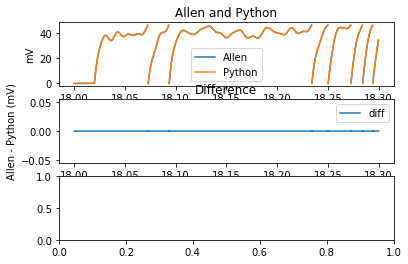

In [4]:
t = saved_model['time']
mask = np.logical_and(t>18, t<18.3)
t_mask = t[mask]
Allen = saved_model['voltage'][mask]*1e3
python = V[mask]*1e3
result = check_nan_arrays_equal(Allen, python)
print("Are results equal: {}".format(result))
plot_results_and_diff(Allen, "Allen", python, "Python", t[mask])


## Allen converted to Python Function - GLIF 2


In [27]:
specimen_ids = [474637203]#, 512322162]
model_types = [ 'LIFR_model'] #, 'LIFASC_model', 'LIFRASC_model', 'LIFRASCAT_model']
saved_models = [f.name for f in Path('./pkl_data').glob('*')]

for specimen_id in specimen_ids:
    for model_type in model_types:
        
        # Find saved Allen model
        for model in saved_models:
            if model.startswith(str(specimen_id)) and model.endswith("_{}.pkl".format(model_type)):
                break
        else:
            raise ValueError("Allen run data not found for specimen: {0} and model type: {1}".format(specimen_id, model_type))

        # Load
        filename = Path('pkl_data', model)
        with open(filename, 'rb') as f:
            saved_model = pickle.load(f)

        # Load config
        for dir in folders:
            sp_id=int(os.path.basename(dir)[:9])
            if sp_id == specimen_id:
                folder=dir
        cre=os.path.basename(folder)[10:]   
        filename = Path(folder, Path(folder).parts[-1] + "_{}_neuron_config.json".format(GLIF_dict[model_type]))   
        with open(filename) as f:
            config = json.load(f)

        # Get stimulus dt, as config file's dt is optimization dt
        dir_name=os.path.join(relative_path, 'mouse_nwb/specimen_'+ str(specimen_id))
        all_sweeps=ctc.get_ephys_sweeps(specimen_id,  os.path.join(dir_name, 'ephys_sweeps.json'))
        sweeps=get_sweep_num_by_name(all_sweeps, 'Noise 2')
        noise2_sweeps = get_sweep_num_by_name(all_sweeps, 'Noise 2')
        noise2_data=ctc.get_ephys_data(specimen_id, os.path.join(dir_name, 'ephys.nwb')).get_sweep(noise2_sweeps[0])
        stimulus=noise2_data['stimulus']
        config['dt']=1./noise2_data['sampling_rate']

        num_steps = len(stimulus)
        V = np.empty(num_steps) 
        V[:] = np.nan
        V_init = config['init_voltage']
        dt = config['dt']
        G = 1/config['R_input']
        El = config['El']
        C = config['C']
        thres = config['th_inf'] * config['coeffs']['th_inf']
        spike_cut_length = config['spike_cut_length']

        T = np.empty(num_steps)
        T[:] = np.nan
        init_threshold = config['init_threshold']
        a_spike = config['threshold_dynamics_method']["params"]["a_spike"]
        b_spike = config['threshold_dynamics_method']["params"]["b_spike"]
        a = config['voltage_reset_method']["params"]["a"]
        b = config['voltage_reset_method']["params"]["b"]

        tcs = None  # threshold components
        voltage_t0 = V_init
        threshold_t0 = init_threshold
        th_spike = 0
        tcs_spike_component = np.empty(num_steps)
        tcs_spike_component[:] = np.nan
        tcs_voltage_component = np.empty(num_steps)
        tcs_voltage_component[:] = np.nan

        i = 0
        while i< num_steps:
            
            # Voltage
            inj = stimulus[i]
            voltage_t1 = voltage_t0 + (inj - G * (voltage_t0 - El))*dt/C # Linear euler equation

            # Threshold
            if i == 0:
                th_spike = 0
            else:
                th_spike = tcs_spike_component[i-1]
            b_spike_neg=-b_spike
            spike_component = th_spike*np.exp(b_spike_neg * dt)  # Exact
            tcs_spike_component[i] = spike_component
            tcs_voltage_component[i] = 0.0
            threshold_t1 = spike_component + thres
            
            # Reset if spike occured (with refractory period)
            if voltage_t1 > threshold_t1:

                # Voltage Reset
                voltage_t0 = El + a*(voltage_t1-El) + b  

                # Threshold Reset
                # TODO: This would error if a spike occurs when i > num_steps - spike_cut_length
                th_spike = tcs_spike_component[i]
                th_voltage = tcs_voltage_component[i]
                t = np.arange(1,spike_cut_length+1)*dt
                b_spike_neg = -b_spike
                spike_comp_decay = th_spike * np.exp(b_spike_neg * t)  # Decay spike component during refractory period
                tcs_spike_component[i+1:i+spike_cut_length+1] = spike_comp_decay
                tcs_voltage_component[i+1:i+spike_cut_length+1] = np.ones(spike_cut_length)*th_voltage
                tcs_spike_component[i+spike_cut_length] += a_spike  # a_spike = delta_theta_s; add additive component
                threshold_t0 = tcs_spike_component[i+spike_cut_length] +tcs_voltage_component[i+spike_cut_length] + thres

                # Extend this to refractory period
                if refractory_beyond_end == True:
                    # Values remain as np.nan
                    i = num_steps
                else:
                    V[i+spike_cut_length] = voltage_t0
                    T[i+spike_cut_length] = threshold_t0
                    i += spike_cut_length + 1

            else:
                V[i] = voltage_t1
                T[i] = threshold_t1

                voltage_t0 = voltage_t1
                threshold_t0 = threshold_t1
                
                i+= 1







Are results equal: True


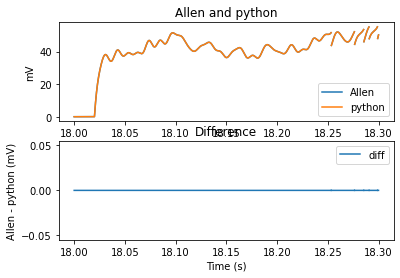

Are results equal: True


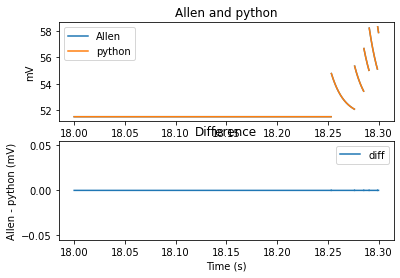

In [30]:

t = saved_model['time']
mask = np.logical_and(t>18, t<18.3)
t_mask = t[mask]

# Plot voltages
Allen = saved_model['voltage'][mask]*1e3
python = V[mask].ravel()*1e3
result = check_nan_arrays_equal(Allen, python)
print("Are results equal: {}".format(result))
plot_results_and_diff(Allen, "Allen", python, "python", t[mask])

# Plot thresholds
Allen = saved_model['threshold'][mask]*1e3
python = T[mask].ravel()*1e3
result = check_nan_arrays_equal(Allen, python)
print("Are results equal: {}".format(result))
plot_results_and_diff(Allen, "Allen", python, "python", t[mask])

## Allen converted to Python Function - GLIF 3


In [7]:
specimen_ids = [474637203]#, 512322162]
model_types = [ 'LIFASC_model']#, 'LIFRASC_model', 'LIFRASCAT_model']
saved_models = [f.name for f in Path('./pkl_data').glob('*')]

for specimen_id in specimen_ids:
    for model_type in model_types:
        
        # Find saved Allen model
        for model in saved_models:
            if model.startswith(str(specimen_id)) and model.endswith("_{}.pkl".format(model_type)):
                break
        else:
            raise ValueError("Allen run data not found for specimen: {0} and model type: {1}".format(specimen_id, model_type))

        # Load
        filename = Path('pkl_data', model)
        with open(filename, 'rb') as f:
            saved_model = pickle.load(f)

        # Load config
        for dir in folders:
            sp_id=int(os.path.basename(dir)[:9])
            if sp_id == specimen_id:
                folder=dir
        cre=os.path.basename(folder)[10:]   
        filename = Path(folder, Path(folder).parts[-1] + "_{}_neuron_config.json".format(GLIF_dict[model_type]))   
        with open(filename) as f:
            config = json.load(f)

        # Get stimulus dt, as config file's dt is optimization dt
        dir_name=os.path.join(relative_path, 'mouse_nwb/specimen_'+ str(specimen_id))
        all_sweeps=ctc.get_ephys_sweeps(specimen_id,  os.path.join(dir_name, 'ephys_sweeps.json'))
        sweeps=get_sweep_num_by_name(all_sweeps, 'Noise 2')
        noise2_sweeps = get_sweep_num_by_name(all_sweeps, 'Noise 2')
        noise2_data=ctc.get_ephys_data(specimen_id, os.path.join(dir_name, 'ephys.nwb')).get_sweep(noise2_sweeps[0])
        stimulus=noise2_data['stimulus']
        config['dt']=1./noise2_data['sampling_rate']

        num_steps = len(stimulus)
        V = np.empty(num_steps) 
        V[:] = np.nan
        V_init = config['init_voltage']
        dt = config['dt']
        G = 1/config['R_input']
        El = config['El']
        C = config['C']
        thres = config['th_inf'] * config['coeffs']['th_inf']
        spike_cut_length = config['spike_cut_length']

        T = np.empty(num_steps)
        T[:] = np.nan
        init_threshold = config['init_threshold']
        a_spike = config['threshold_dynamics_method']["params"]["a_spike"]
        b_spike = config['threshold_dynamics_method']["params"]["b_spike"]
        coeffs = config["coeffs"]
        a = config['voltage_reset_method']["params"]["a"]
        b = config['voltage_reset_method']["params"]["b"]

        tcs = None  # threshold components
        voltage_t0 = V_init
        threshold_t0 = init_threshold
        th_spike = 0
        tcs_spike_component = np.empty(num_steps)
        tcs_spike_component[:] = np.nan
        tcs_voltage_component = np.empty(num_steps)
        tcs_voltage_component[:] = np.nan

        i = 0
        while i< num_steps:
            
            # Voltage
            inj = stimulus[i]
            voltage_t1 = voltage_t0 + (inj - G * (voltage_t0 - El))*dt/C # Linear euler equation

            # Threshold
            # if tcs is None:
            #     tcs = {'spike':[], 'voltage':[]}
            #     th_spike = 0
            # else:
            #     th_spike = tcs['spike'][-1]
            if i == 0:
                th_spike = 0
            else:
                th_spike = tcs_spike_component[i-1]

            b_spike_neg=-b_spike
            spike_component = th_spike*np.exp(b_spike_neg * dt)  # Exact
            # tcs['spike'].append(spike_component)
            # tcs['voltage'].append(0.0)
            tcs_spike_component[i] = spike_component
            tcs_voltage_component[i] = 0.0
            threshold_t1 = spike_component + thres
            
            # Reset if spike occured (with refractory period)
            if voltage_t1 > threshold_t1:

                # Voltage Reset
                voltage_t0 = El + a*(voltage_t1-El) + b  

                # Threshold Reset
                # TODO: This would error if a spike occurs when i > num_steps - spike_cut_length
                # th_spike = tcs['spike'][-1]
                # th_voltage = tcs['voltage'][-1]
                th_spike = tcs_spike_component[i]
                th_voltage = tcs_voltage_component[i]
                t = np.arange(1,spike_cut_length+1)*dt
                b_spike_neg = -b_spike
                spike_comp_decay = th_spike * np.exp(b_spike_neg * t)
                # [tcs['voltage'].append(value) for value in np.ones(spike_cut_length)*th_voltage] #note that here I don't need the plus one because I am starting from zero
                # [tcs['spike'].append(value) for value in spike_comp_decay]
                tcs_spike_component[i+1:i+spike_cut_length+1] = spike_comp_decay
                tcs_voltage_component[i+1:i+spike_cut_length+1] = np.ones(spike_cut_length)*th_voltage
                # tcs['spike'][-1]=tcs['spike'][-1]+a_spike
                tcs_spike_component[i+spike_cut_length] += a_spike  # a_spike = delta_theta_s
                # threshold_t0 = tcs['spike'][-1] + tcs['voltage'][-1] + thres
                threshold_t0 = tcs_spike_component[i+spike_cut_length] +tcs_voltage_component[i+spike_cut_length] + thres

                # Extend this to refractory period
                refractory_beyond_end = i + spike_cut_length >= num_steps
                if refractory_beyond_end == True:
                    i = num_steps
                else:
                    V[i+spike_cut_length] = voltage_t0
                    T[i+spike_cut_length] = threshold_t0
                    i += spike_cut_length + 1

            else:
                V[i] = voltage_t1
                T[i] = threshold_t1

                voltage_t0 = voltage_t1
                threshold_t0 = threshold_t1
                
                i+= 1


KeyError: 'a_spike'

## Run GeNN simulation

In [42]:
from pygenn.genn_model import create_custom_current_source_class, GeNNModel
specimen_ids = [474637203]#, 512322162]
model_types = ['LIFR_model'] 
saved_models = [f.name for f in Path('./pkl_data').glob('*')]

for specimen_id in specimen_ids:
    for model_type in model_types:
        
        # Find saved Allen model
        for model in saved_models:
            if model.startswith(str(specimen_id)) and model.endswith("_{}.pkl".format(model_type)):
                break
        else:
            raise ValueError("Allen run data not found for specimen: {0} and model type: {1}".format(specimen_id, model_type))

        # Load
        filename = Path('pkl_data', model)
        with open(filename, 'rb') as f:
            saved_model = pickle.load(f)

        # Load config
        for dir in folders:
            sp_id=int(os.path.basename(dir)[:9])
            if sp_id == specimen_id:
                folder=dir
        cre=os.path.basename(folder)[10:]   
        filename = Path(folder, Path(folder).parts[-1] + "_{}_neuron_config.json".format(GLIF_dict[model_type]))   
        with open(filename) as f:
            config = json.load(f)

        # Get stimulus dt, as config file's dt is optimization dt
        dir_name=os.path.join(relative_path, 'mouse_nwb/specimen_'+ str(specimen_id))
        all_sweeps=ctc.get_ephys_sweeps(specimen_id,  os.path.join(dir_name, 'ephys_sweeps.json'))
        sweeps=get_sweep_num_by_name(all_sweeps, 'Noise 2')
        noise2_sweeps = get_sweep_num_by_name(all_sweeps, 'Noise 2')
        noise2_data=ctc.get_ephys_data(specimen_id, os.path.join(dir_name, 'ephys.nwb')).get_sweep(noise2_sweeps[0])
        stimulus=noise2_data['stimulus']
        config['dt']=1./noise2_data['sampling_rate']

        # Convert Allen Units (SI) to PyGenn
        units_dict = {
            'C': config['C'] * 1e9,  # F -> nF
            'G': 1 / config['R_input'] * 1e6,  # S -> uS
            'El': config['El'] * 1e3, # V -> mV
            'th_inf': config['th_inf'] * config['coeffs']['th_inf'] * 1e3, # V -> mV
            'dT' : config['dt'] * 1e3,  # s -> ms
            'V': config['init_voltage'] * 1e3,  # V -> mV,
            'spike_cut_length': config['spike_cut_length'],
            'refractory_count' : -1,
            'a': config['voltage_reset_method']["params"]["a"], 
            'b': config['voltage_reset_method']["params"]["b"] * 1e3,  # V -> mV
            "a_spike": config['threshold_dynamics_method']['params']["a_spike"]*1e3, # V -> mV
            "b_spike": config['threshold_dynamics_method']['params']["b_spike"]*1e-3, # inverse of s -> ms
            'th_s': config['init_threshold'] * 1e3, # V -> mV
        }

        # Add GLIF Class to model
        from importlib import reload
        import GLIF_models
        reload(GLIF_models)
        from GLIF_models import GLIF1, GLIF2
        num_neurons = 1
        GLIF = eval(GLIF_dict[model_type])
        GLIF_params = {k:units_dict[k] for k in GLIF.get_param_names()}
        GLIF_init = {k:units_dict[k] for k in ['V', 'refractory_count', 'th_s']}
        model = GeNNModel("double", GLIF_dict[model_type], backend='SingleThreadedCPU')
        model.dT=units_dict['dT']
        pop1 = model.add_neuron_population(
            pop_name = "pop1",
            num_neurons = num_neurons,
            neuron = GLIF,
            param_space = GLIF_params,
            var_space = GLIF_init,
        )

        ### Add current source to model ###
        external_current_source = create_custom_current_source_class(
            class_name = "external_current",
            var_name_types = [("current", "double") ],  
            injection_code = """
            $(current)=$(Ie)[int($(t) / DT)];
            $(injectCurrent,$(current) );
            """,
            extra_global_params=[("Ie", "double*")]
        )
        cs_ini = {"current":0.0}  # external input current from Teeter 2018
        cs = model.add_current_source(
            cs_name = "external_current_source", 
            current_source_model=external_current_source,
            pop = pop1,
            param_space = {},
            var_space = cs_ini)

        scale = 1e9  # amps -> nanoamps
        cs.set_extra_global_param("Ie", stimulus*scale)

        model.build()
        model.load()

        # Run a quick simulation
        num_steps = len(stimulus)
        v = np.empty((num_steps, num_neurons))
        v_view = pop1.vars["V"].view
        T = np.ones((num_steps, num_neurons))* config['th_inf'] * config['coeffs']['th_inf'] * 1e3
        T_view = pop1.vars["th_s"].view
        for i in range(num_steps):
            model.step_time()
            pop1.pull_var_from_device("V")            
            v[model.timestep - 1,:]=v_view[:]
            pop1.pull_var_from_device("th_s")
            T[model.timestep -1, :]+=T_view[:]
            




Are results equal: False


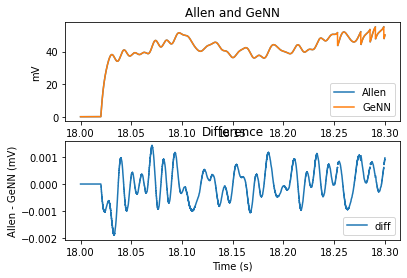

Are results equal: False


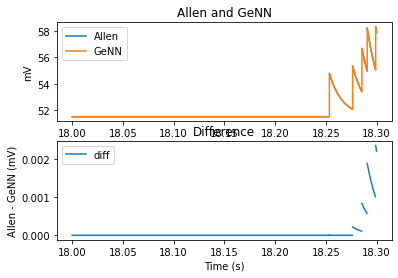

In [43]:

t = saved_model['time']
mask = np.logical_and(t>18, t<18.3)
t_mask = t[mask]

# Plot voltages
Allen = saved_model['voltage'][mask]*1e3
GeNN = v[mask, :].ravel()
result = check_nan_arrays_equal(Allen, GeNN)
print("Are results equal: {}".format(result))
plot_results_and_diff(Allen, "Allen", GeNN, "GeNN", t[mask])

# Plot thresholds
Allen = saved_model['threshold'][mask]*1e3
GeNN = T[mask, :].ravel()
result = check_nan_arrays_equal(Allen, GeNN)
print("Are results equal: {}".format(result))
plot_results_and_diff(Allen, "Allen", GeNN, "GeNN", t[mask])

In [18]:
diff = Allen - GeNN
np.sum(diff>2)

5

In [10]:
Allen

array([5.47814542e-308, 5.47814542e-308, 5.47814542e-308, ...,
       5.01092382e+001, 5.01221809e+001, 5.01351243e+001])

In [13]:
GeNN

array([1.01033619e-42, 1.01033619e-42, 1.01033619e-42, ...,
       5.01081734e+01, 5.01211166e+01, 5.01340599e+01])

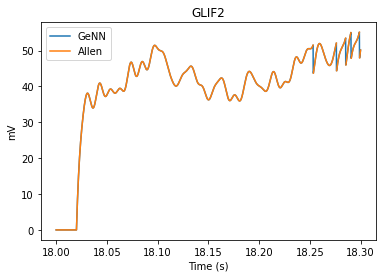

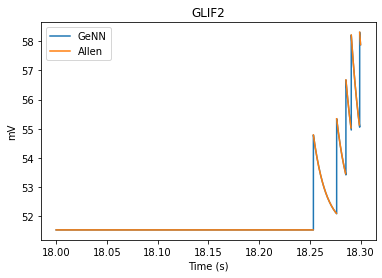

In [ ]:
# Plot the results
fig, axs = plt.subplots(1,1)

# Full run
t = saved_model['time']
# axs[0].plot(t, v[:num_steps,:], label='GeNN')
# axs[0].plot(t, saved_model['voltage']*1e3, label='Allen')
# axs[0].set_xlabel('Time (s)')
# axs[0].set_ylabel('mV')
# axs[0].set_title('Full Run Time')

# Subset of run
mask = np.logical_and(t>18, t<18.3)
axs.plot(t[mask], v[mask,:], label='GeNN')
axs.plot(t[mask], saved_model['voltage'][mask]*1e3, label='Allen')
axs.set_xlabel('Time (s)')
axs.set_ylabel('mV')
axs.set_title('Run Time on [18, 18.3]')
plt.title(GLIF_dict[model_type])
plt.legend()
plt.show()

# Plot the results
fig, axs = plt.subplots(1,1)

# Subset of run
mask = np.logical_and(t>18, t<18.3)
axs.plot(t[mask], T[mask,:], label='GeNN')
axs.plot(t[mask], saved_model['threshold'][mask]*1e3, label='Allen')
axs.set_xlabel('Time (s)')
axs.set_ylabel('mV')
axs.set_title('Run Time on [18, 18.3]')
plt.title(GLIF_dict[model_type])
plt.legend()
plt.show()


# Plot the results
fig, axs = plt.subplots(1,1)

# Full run
t = saved_model['time']
# axs[0].plot(t, v[:num_steps,:], label='GeNN')
# axs[0].plot(t, saved_model['voltage']*1e3, label='Allen')
# axs[0].set_xlabel('Time (s)')
# axs[0].set_ylabel('mV')
# axs[0].set_title('Full Run Time')

# Subset of run
mask = np.logical_and(t>18, t<18.3)
axs.plot(t[mask], T[mask,:], label='GeNN')
axs.plot(t[mask], saved_model['threshold'][mask]*1e3, label='Allen')
axs.set_xlabel('Time (s)')
axs.set_ylabel('mV')
axs.set_title('Run Time on [18, 18.3]')
plt.title(GLIF_dict[model_type])
plt.legend()
plt.show()

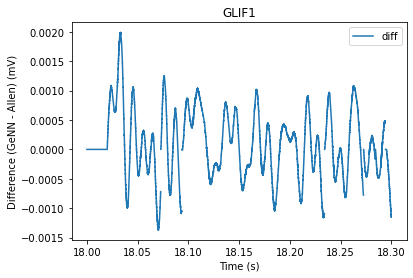

In [ ]:
allen = saved_model['voltage'][mask] * 1e3
diff = v[mask,:].T - allen

fig, axs = plt.subplots(1)
t = saved_model['time']
mask = np.logical_and(t>18, t<18.3)
axs.plot(t[mask], diff.ravel(),  label='diff')
axs.set_xlabel('Time (s)')
axs.set_ylabel('Difference (GeNN - Allen) (mV)')
axs.set_title('Run Time on [18, 18.3]')
plt.title(GLIF_dict[model_type])
plt.legend()
plt.show()